<a href="https://colab.research.google.com/github/Lukehsu1999/BraTS2025/blob/main/monai_3d_seg_BraTS_T7_0513_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Spleen 3D segmentation with MONAI

This tutorial shows how to integrate MONAI into an existing PyTorch medical DL program.

And easily use below features:
1. Transforms for dictionary format data.
1. Load Nifti image with metadata.
1. Add channel dim to the data if no channel dimension.
1. Scale medical image intensity with expected range.
1. Crop out a batch of balanced images based on positive / negative label ratio.
1. Cache IO and transforms to accelerate training and validation.
1. 3D UNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
1. Sliding window inference method.
1. Deterministic training for reproducibility.

The Spleen dataset can be downloaded from http://medicaldecathlon.com/.

![spleen](https://github.com/Project-MONAI/tutorials/blob/main/figures/spleen0.png?raw=1)

Target: Spleen  
Modality: CT  
Size: 61 3D volumes (41 Training + 20 Testing)  
Source: Memorial Sloan Kettering Cancer Center  
Challenge: Large ranging foreground size

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/3d_segmentation/spleen_segmentation_3d.ipynb)

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.3 MB/s eta 0:00:00
  

## Setup imports

In [2]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    ScaleIntensityRangePercentilesd,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

print_config()

MONAI version: 1.5.dev2519
Numpy version: 2.0.2
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 552815d9e48a40cf72c7c718034df7984f5d14dd
MONAI __file__: /usr/local/lib/python3.11/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.15.2
Pillow version: 11.2.1
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.1
transformers version: 4.51.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.htm

## Wandb Logging

In [3]:
import wandb

# --- Configs from your WandB init ---
epochs = 600
lr = 1e-4
batch_size = 2
loss_func = "DiceLoss"
model = "3D UNet"
modality = "FLAIR"

train_cnt, val_cnt, test_cnt = 40, 10, 100

# --- WandB ---
run = wandb.init(
    project="BraTS",
    name="T7_mini_exp2",
    config={
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        "loss_func": loss_func,
        "model": model,
        "train_cnt": train_cnt,
        "val_cnt": val_cnt,
        "test_cnt": test_cnt,
        "modality": modality,
    },
    reinit=True,
    settings=wandb.Settings(code_dir="")
)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: lukehsu1999 (luke-cmuh) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


In [47]:
wandb.config.update({"modality":"FLAIR"})

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpsyac784h


## Mount on Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Set MSD Spleen dataset path

In [6]:
import glob
import os

data_dir = "/content/drive/MyDrive/BraTS2025/miniset50"

# Recursively find FLAIR and binary mask pairs
image_paths = sorted(glob.glob(os.path.join(data_dir, "**", "*t2f.nii.gz"), recursive=True))
label_paths = sorted(glob.glob(os.path.join(data_dir, "**", "*seg_binary.nii.gz"), recursive=True))

# Make sure they align
assert len(image_paths) == len(label_paths), "Mismatch in image and label counts!"

data_dicts = [{"image": i, "label": l} for i, l in zip(image_paths, label_paths)]

# Manual split: last N for validation
train_files = data_dicts[:-val_cnt]  # adjust N based on your total case count
val_files   = data_dicts[-val_cnt:]

print(f"✅ Total cases: {len(data_dicts)}")
print(f"📊 Training: {len(train_files)}  | Validation: {len(val_files)}")

✅ Total cases: 50
📊 Training: 40  | Validation: 10


## Set deterministic training for reproducibility

In [7]:
set_determinism(seed=0)

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.

In [14]:
from monai.transforms import SpatialPadd
pad_roi = (64, 96, 64)

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRangePercentilesd(
            keys=["image"],
            lower=0.5,     # 0.5 percentile
            upper=99.5,    # 99.5 percentile
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        SpatialPadd(keys=["image", "label"], spatial_size=pad_roi),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(64, 96, 64),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRangePercentilesd(
            keys=["image"],
            lower=0.5,     # 0.5 percentile
            upper=99.5,    # 99.5 percentile
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

## Check transforms in DataLoader

image shape: torch.Size([94, 113, 70]), label shape: torch.Size([94, 113, 70])


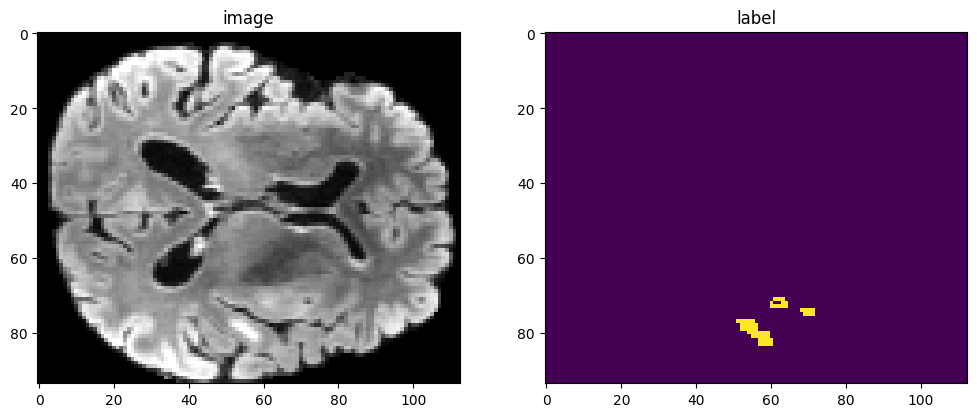

In [15]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 20]
idx = 40
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, idx], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, idx])
plt.show()

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [16]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


## Create Model, Loss, Optimizer

In [17]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

## Execute a typical PyTorch training process

In [18]:
from tqdm import tqdm, trange

In [19]:
max_epochs = 600
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])


epoch_range = trange(max_epochs, desc="Training Epochs")

for epoch in epoch_range:
    #print("-" * 10)
    #print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        #print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    epoch_range.set_postfix({"loss": epoch_loss})
    wandb.log({"train/loss": epoch_loss}, step=epoch)
    #print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)

            wandb.log({"val/dice": metric}, step=epoch)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            # print(
            #     f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
            #     f"\nbest mean dice: {best_metric:.4f} "
            #     f"at epoch: {best_metric_epoch}"
            # )

Training Epochs:   0%|          | 2/600 [00:21<1:52:32, 11.29s/it, loss=0.612]

saved new best metric model


Training Epochs:   1%|          | 4/600 [00:43<1:51:51, 11.26s/it, loss=0.571]

saved new best metric model


Training Epochs:   1%|          | 6/600 [01:05<1:52:03, 11.32s/it, loss=0.55]

saved new best metric model


Training Epochs:   1%|▏         | 8/600 [01:28<1:52:04, 11.36s/it, loss=0.532]

saved new best metric model


Training Epochs:   2%|▏         | 12/600 [02:14<1:56:06, 11.85s/it, loss=0.502]

saved new best metric model


Training Epochs:   3%|▎         | 16/600 [03:01<1:55:46, 11.90s/it, loss=0.466]

saved new best metric model


Training Epochs:   5%|▌         | 30/600 [05:41<1:52:01, 11.79s/it, loss=0.353]

saved new best metric model


Training Epochs:   6%|▌         | 34/600 [06:26<1:48:47, 11.53s/it, loss=0.319]

saved new best metric model


Training Epochs:   8%|▊         | 48/600 [09:05<1:45:52, 11.51s/it, loss=0.227]

saved new best metric model


Training Epochs:   8%|▊         | 50/600 [09:28<1:45:47, 11.54s/it, loss=0.205]

saved new best metric model


Training Epochs:  10%|█         | 60/600 [11:21<1:44:34, 11.62s/it, loss=0.165]

saved new best metric model


Training Epochs:  13%|█▎        | 80/600 [15:06<1:39:17, 11.46s/it, loss=0.0994]

saved new best metric model


Training Epochs:  33%|███▎      | 200/600 [36:55<1:13:51, 11.08s/it, loss=0.0406]

saved new best metric model


Training Epochs:  38%|███▊      | 228/600 [42:03<1:11:12, 11.48s/it, loss=0.0374]

saved new best metric model


Training Epochs:  39%|███▊      | 232/600 [42:47<1:09:53, 11.40s/it, loss=0.0358]

saved new best metric model


Training Epochs:  47%|████▋     | 280/600 [51:34<1:01:01, 11.44s/it, loss=0.0364]

saved new best metric model


Training Epochs:  47%|████▋     | 284/600 [52:17<58:44, 11.15s/it, loss=0.0332]

saved new best metric model


Training Epochs:  58%|█████▊    | 350/600 [1:04:17<46:47, 11.23s/it, loss=0.0296]

saved new best metric model


Training Epochs:  61%|██████▏   | 368/600 [1:07:33<43:20, 11.21s/it, loss=0.0312]

saved new best metric model


Training Epochs:  64%|██████▍   | 384/600 [1:10:29<40:37, 11.29s/it, loss=0.0311]

saved new best metric model


Training Epochs: 100%|██████████| 600/600 [1:49:58<00:00, 11.00s/it, loss=0.031]


In [20]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.6558 at epoch: 384


## Plot the loss and metric

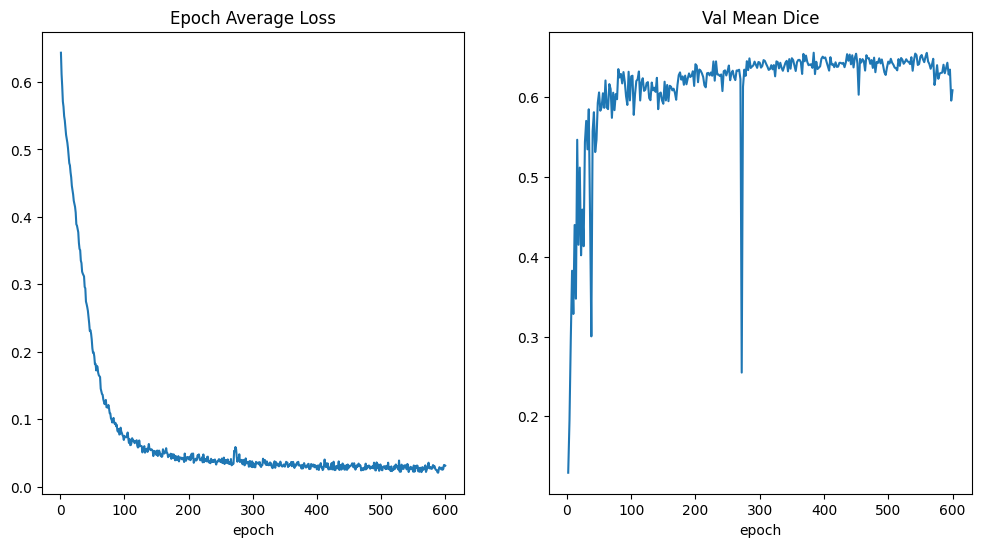

In [21]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

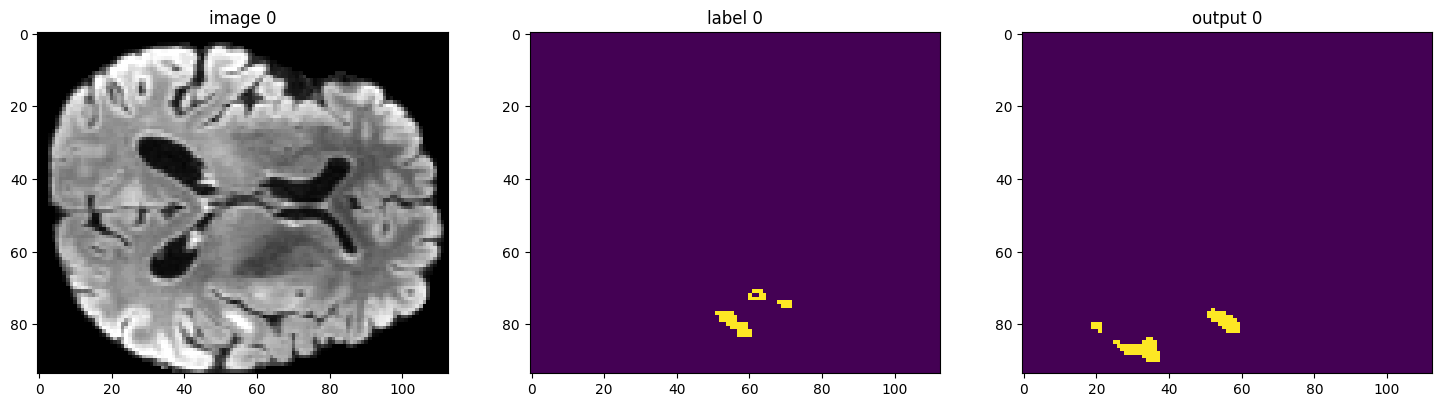

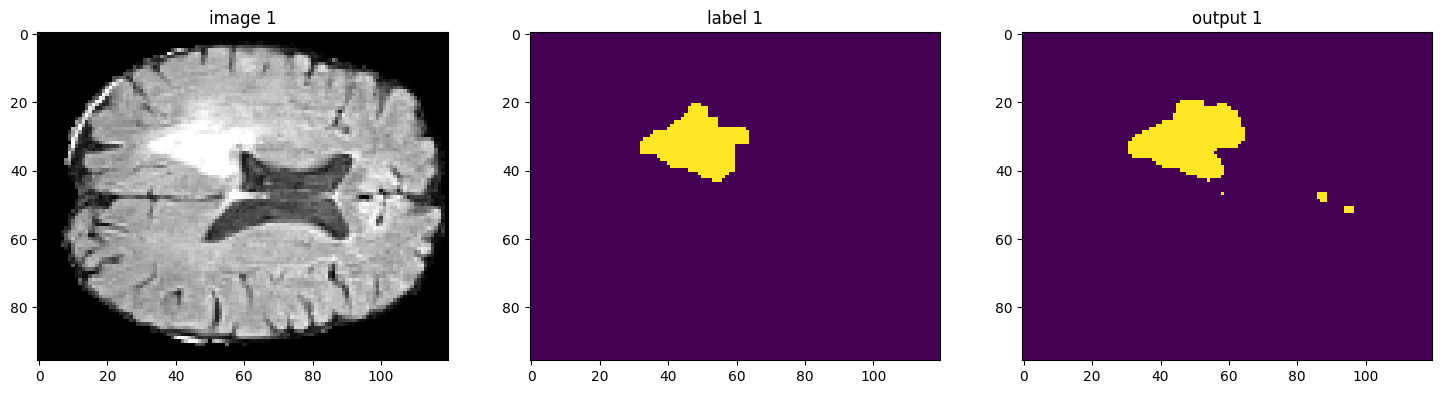

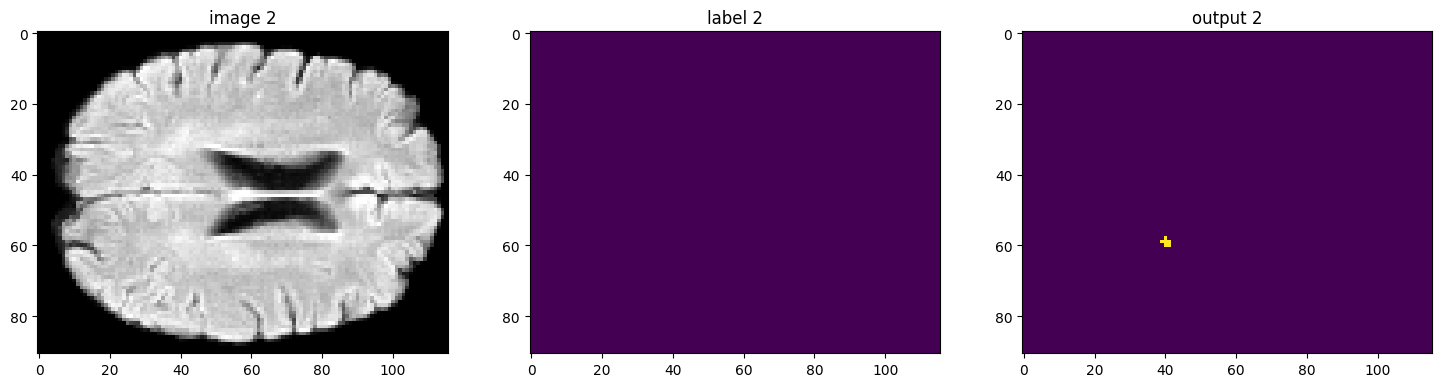

In [22]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), weights_only=True))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        idx = 40
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :,idx], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, idx])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, idx])
        plt.show()
        if i == 2:
            break

## Evaluation on original image spacings

In [27]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRangePercentilesd(
            keys=["image"],
            lower=0.5,     # 0.5 percentile
            upper=99.5,    # 99.5 percentile
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image", allow_smaller=True),
    ]
)

val_org_ds = Dataset(data=val_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        AsDiscreted(keys="label", to_onehot=2),
    ]
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [28]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), weights_only=True))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

Metric on original image spacing:  0.6563552618026733


In [29]:
wandb.config.update({"val_metric_orig_spacing": metric_org})

## Inference on Test Set

In [37]:
test_dir = "/content/drive/MyDrive/BraTS2025/static_test_set"

test_images = sorted(glob.glob(os.path.join(test_dir, "**", "*t2f.nii.gz"), recursive=True))
test_labels = sorted(glob.glob(os.path.join(test_dir, "**", "*seg_binary.nii.gz"), recursive=True))



test_data = [{"image": img, "label": lbl} for img, lbl in zip(test_images, test_labels)]


test_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ScaleIntensityRangePercentilesd(
            keys=["image"],
            lower=0.5,     # 0.5 percentile
            upper=99.5,    # 99.5 percentile
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
    CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),
])

# === 3. Dataset & Loader ===
test_ds = Dataset(data=test_data, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=4)

# === 4. Post transforms ===
post_transforms = Compose([
    AsDiscreted(keys="pred", argmax=True, to_onehot=2),
    AsDiscreted(keys="label", to_onehot=2),
])

# === 5. Metric ===
dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=True)

# === 6. Load Model ===
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.to(device)
model.eval()

# === 7. Inference & Evaluation ===
with torch.no_grad():
    for test_data in test_loader:
        test_inputs = test_data["image"].to(device)
        test_labels = test_data["label"].to(device)

        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_outputs = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model)

        # Post-processing
        test_data = decollate_batch(test_data)
        test_outputs = decollate_batch(test_outputs)

        test_data = [{"pred": p, "label": d["label"]} for p, d in zip(test_outputs, test_data)]
        test_data = [post_transforms(i) for i in test_data]

        preds = [i["pred"].to(device) for i in test_data]
        labels = [i["label"].to(device) for i in test_data]

        dice_metric(y_pred=preds, y=labels)

# === 8. Final Dice Score ===
metric, _ = dice_metric.aggregate()
metric = metric.item()
print(f"✅ Mean Dice on Test Set: {metric:.4f}")
dice_metric.reset()

✅ Mean Dice on Test Set: 0.7616


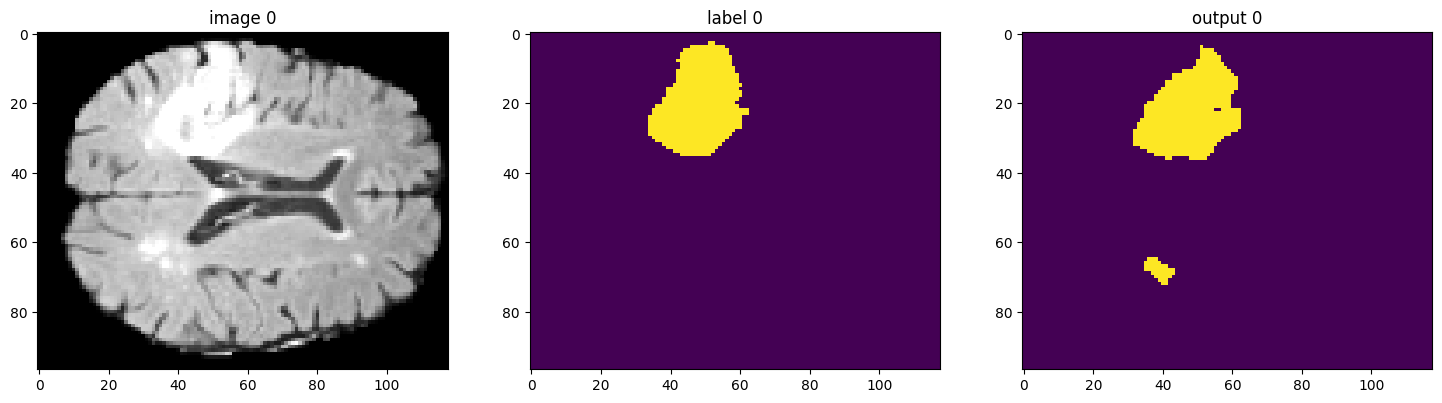

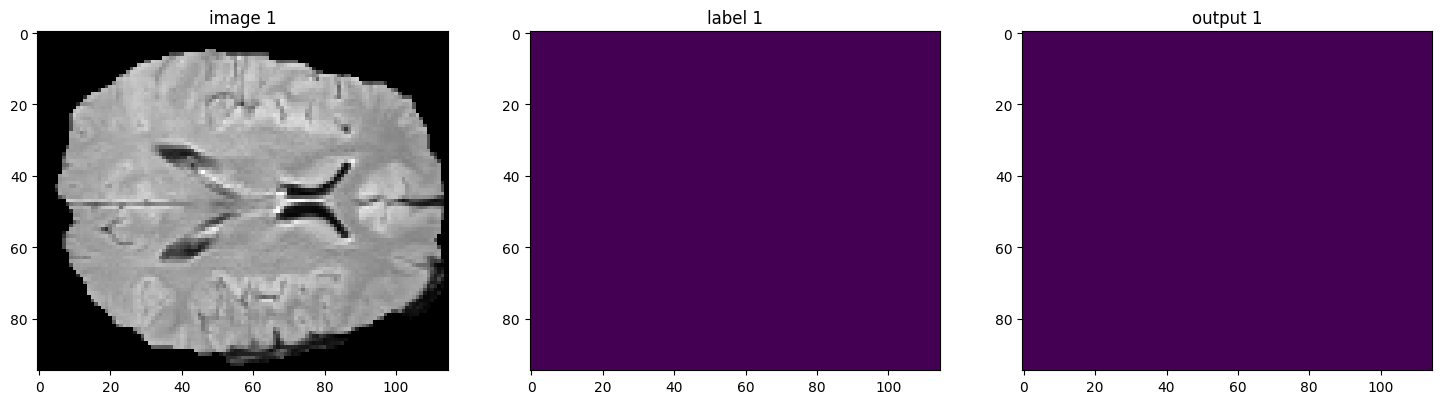

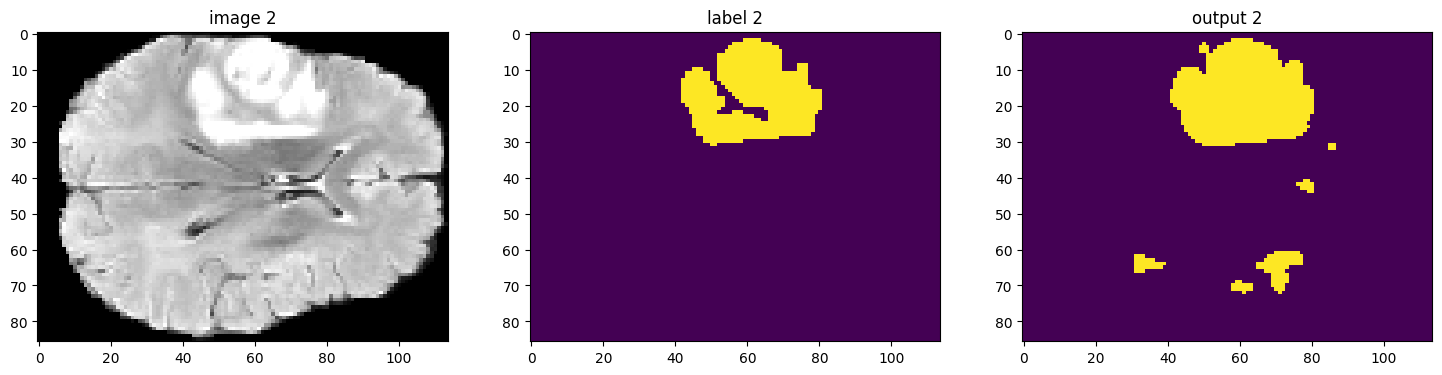

In [38]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), weights_only=True))
model.eval()
with torch.no_grad():
    for i, test_data in enumerate(test_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_outputs = sliding_window_inference(test_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        idx = 40
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_data["image"][0, 0, :, :,idx], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(test_data["label"][0, 0, :, :, idx])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(test_outputs, dim=1).detach().cpu()[0, :, :, idx])
        plt.show()
        if i == 2:
            break

In [43]:
print(metric)

0.7615818977355957


In [46]:
wandb.log({"test/dice_mean": metric}, step=0)

In [ ]:
# # uncomment the following lines to visualize the predicted results
# from monai.transforms import LoadImage
# loader = LoadImage()

In [ ]:
# model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), weights_only=True))
# model.eval()

# with torch.no_grad():
#     for test_data in test_org_loader:
#         test_inputs = test_data["image"].to(device)
#         roi_size = (160, 160, 160)
#         sw_batch_size = 4
#         test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model)

#         test_data = [post_transforms(i) for i in decollate_batch(test_data)]

# #         # uncomment the following lines to visualize the predicted results
# #         test_output = from_engine(["pred"])(test_data)

# #         original_image = loader(test_output[0].meta["filename_or_obj"])

# #         plt.figure("check", (18, 6))
# #         plt.subplot(1, 2, 1)
# #         plt.imshow(original_image[:, :, 20], cmap="gray")
# #         plt.subplot(1, 2, 2)
# #         plt.imshow(test_output[0].detach().cpu()[1, :, :, 20])
# #         plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)